## Estimating Diagonal OT Maps Using RQ Splines

In [1]:
import sys
sys.path.append("../../../")
sys.path.append('../../')
import os
import time
import json
import torch
from tqdm import tqdm
from itertools import cycle
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
from torch.nn import functional as F
import matplotlib.pyplot as plt


from potential_flows import transforms, potential, encoders, data, flow
from potential_flows.data import get_dataset, create_custom_dataset
from flow.arguments import set_seed, parse_arguments, parse_notebook_arguments, get_parser

In this notebook, we will compare the performance of dual and minimax methods for finding the Kantorovich dual parameterized as input convex rational quadratic (ICRQ) splines. Briefly, suppose we want to optimaly (using quadratic cost function) transport an absolutely continuous distribution $P \in \mathcal{P}^2(\Omega_P)$ to $Q \in \mathcal{P}^2(\Omega_Q)$. The Brenier potential $f_0: \Omega_P \to \mathbb{R}$ gives us the Brenier map (optimal transport map) as $T_0 = \nabla f$. 

### Learning optimal transport map by solving the Kantororvich semi-dual problem

The Kantorovich semi dual problem can be written as 
$$W_2^2(P,Q) = C_{P,Q} - \inf_{f \in CVX(P)} (\mathbb{E}_P[f(X)] + \mathbb{E}_Q[f^*(X)])$$
where $f^*$ is the Legendre transform of $f$ defined as $f^*(y) := \sup_{x\in \Omega_P} \langle x, y \rangle - f(x)$ and $\texttt{CVX}(P)$ denotes the set of all convex functions in $L^1(P)$.
The above problem is solved by parameterizing $f$ using input-convex rational quadratic splines.

### Learning optimal transport map by solving a minimax problem

Makkuva et.al (2020) proposed a simplication of the dual problem by getting rid of the convex conjugate of $f$. The resulting optimization problem is the following minimax problem 
$$\mathbb{W}^2_2(P,Q) = \sup_{g \in \texttt{CVX}(Q)} \inf_{f \in \texttt{CVX}(P)} \Eta_{P,Q}(f,g)$$
where
$$\Eta_{P,Q} (f,g) = \left\{ -\mathbb{E}_Q[g(Y)] - \mathbb{E}_P[\langle X, \nabla f(X) \rangle - g(\nabla f(X))] \right\}.$$


The above problem is solved by parameterizing both $f$ and $g$ using input-convex rational quadratic splines. In the RQ spline parameterization, let $f$ be denoted $\phi_{\theta_f}$ and $g$ be denoted $\phi_{\theta_g}$. The algorithm used to solve the above minimax problem is

*****
1. Optimizer using Adam Optimizer

    **Input:** Target distribution $P$, reference distribution $Q$. Batch size $M$. Number of inner loop iterations $N$. Total number of iterations $T$.  
    * **for** $t = 1, \dots, T$ **do**   
        * **for** $k = 1, \dots, N$ **do**  
            * Sample batch $\{X_i\}_{i=1}^M \sim P$ and $\{Y_i\}_{i=1}^{M} \sim Q$.
            * Define $\Eta_M(\theta_f, \theta_g) := M^{-1} \sum_{i=1}^{M} \left[ -g(Y_i) - \langle X_i, \nabla f(X_i) + g(\nabla f(X_i)) \right]$.
            * Update $\theta_f \leftarrow \texttt{Adam}(\Eta_M, \theta_f) $ to minimize objective using Adam optimizer
        * **end for**
        * Sample batch $\{U_i\}_{i=1}^M \sim P$ and $\{V_i\}_{i=1}^{M} \sim Q$.
        * Define $\tilde \Eta_M(\theta_f, \theta_g) := M^{-1} \sum_{i=1}^{M} \left[ -g(V_i) - \langle U_i, \nabla f(U_i) + g(\nabla f(U_i)) \right]$
        * Update $\theta_g \leftarrow \texttt{Adam}(-\tilde \Eta_M, \theta_g)$ to maximize objective using Adam optimizer.
    * **end for**

****


Using our implementation, the derivative of ICRQ splines is a diagonal map. Therefore, in this notebook we compare the performance of two methods described above on transport maps where the true transport map is indeed diagonal.

### Example 1: Gaussian to Gaussian case

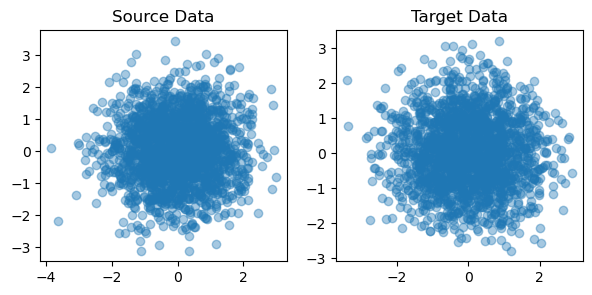

In [6]:
torch.manual_seed(42)
args = parse_notebook_arguments()
args.verbose = False
args.log_interval = 10

# creating dataset and data loaders

dataset_x, dataset_y = get_dataset(args, split = "train")  ## train dataset
test_x, test_y = get_dataset(args, split = "test")  ## test dataset


data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

# plot data

fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1], alpha=.4)
axs[0].set_title("Source Data")
axs[1].scatter(dataset_y.data[:,0], dataset_y.data[:,1], alpha=.4)
axs[1].set_title("Target Data")
plt.show()

#### Dual Method

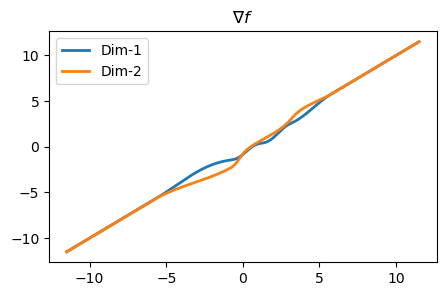

In [3]:
# creating the flow

tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
potential_flow = potential.ICRQ(tail_bound=tail_bound*args.tail_factor, num_bins=4, data_shape=(2,))

# plotting the flow

potential_flow.plot_flow(1000)

In [4]:
# creating OT Trainer

OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)

In [6]:
OT_Trainer.learn()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 40%|███▉      | 1999/5000 [18:01<27:03,  1.85it/s] 


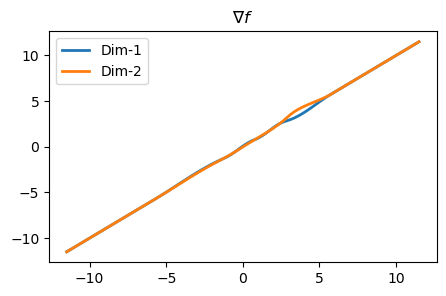

In [7]:
OT_Trainer.potential_flow.plot_flow()

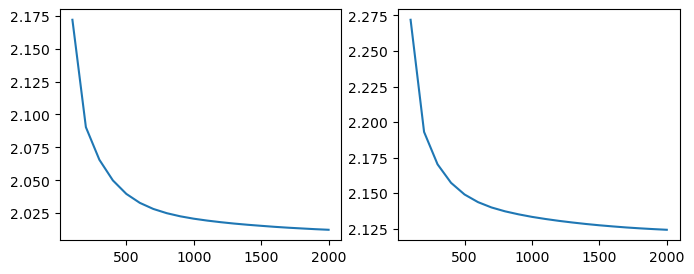

In [8]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

#### Minmax Method

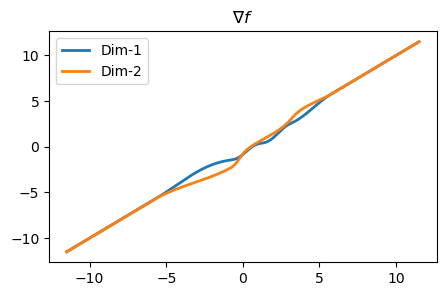

In [7]:
# create the potential flow for f and g

potential_flow_x = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)
potential_flow_y = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)

potential_flow_x.plot_flow(1000)

In [8]:
# train

OT_Trainer = flow.MinmaxOT_Trainer(potential_flow_x, potential_flow_y, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)       
OT_Trainer.learn()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  2%|▏         | 112/5000 [02:26<1:46:38,  1.31s/it]

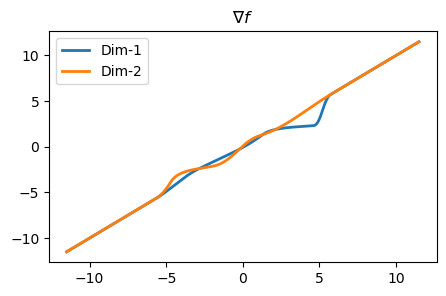

In [11]:
# plot the flow

OT_Trainer.potential_flow_x.plot_flow(1000)

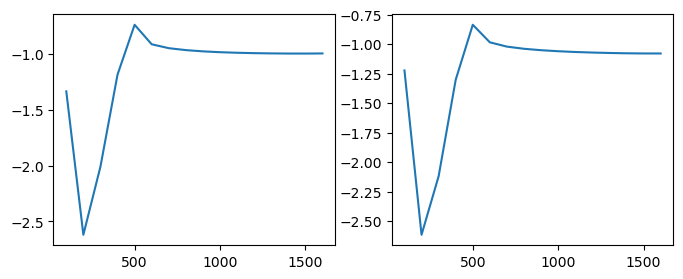

In [12]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
    
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

### Example 2: Four Gaussian 

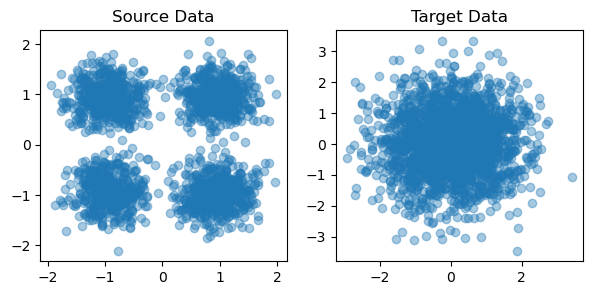

In [4]:
torch.manual_seed(42)
args = parse_notebook_arguments()
args.source_dist = "four_gaussians"
args.verbose = False

dataset_x, dataset_y = get_dataset(args, split = "train")  ## train dataset
test_x, test_y = get_dataset(args, split = "test")  ## test dataset

# creating data loaders

data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1], alpha=.4)
axs[0].set_title("Source Data")
axs[1].scatter(dataset_y.data[:,0], dataset_y.data[:,1], alpha=.4)
axs[1].set_title("Target Data")
plt.show()

#### Dual Method

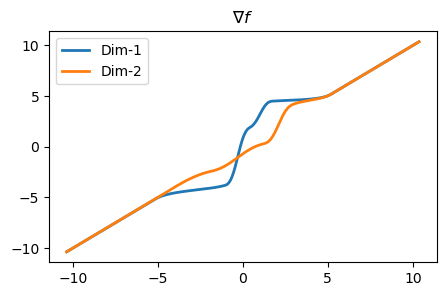

In [6]:
# creating the flow

tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
potential_flow = potential.ICRQ(tail_bound=tail_bound*args.tail_factor, num_bins=4, data_shape=(2,))

# plotting the flow

potential_flow.plot_flow(1000)

In [12]:


# creating OT Trainer

OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)

In [13]:
OT_Trainer.potential_flow = torch.load(OT_Trainer.exp_dir+'/best_flow.t')

In [5]:
# OT_Trainer.learn() # uncomment to learn

  0%|          | 0/5000 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 70%|██████▉   | 3499/5000 [19:12<08:14,  3.04it/s]


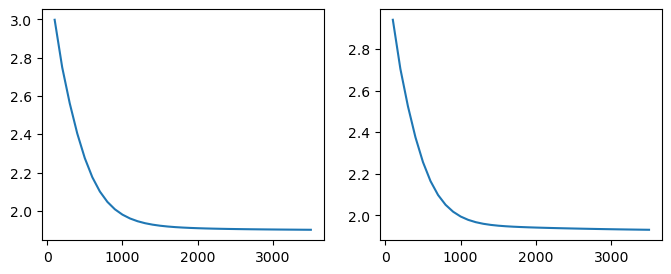

In [15]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
    
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

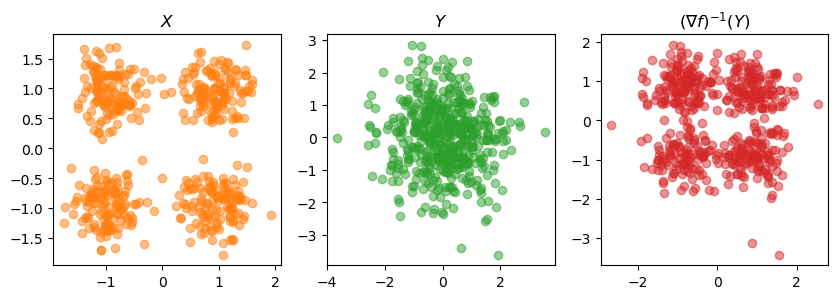

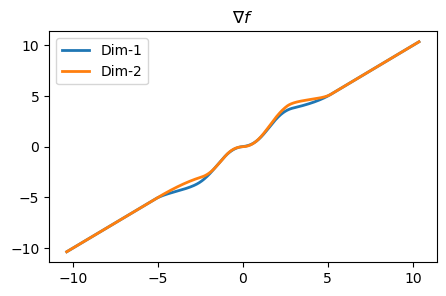

In [16]:
OT_Trainer.args.show_the_plot=True
OT_Trainer.save_figure()

#### Minmax Method

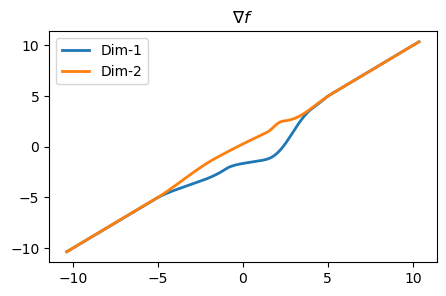

In [7]:

# create the potential flow for f and g

potential_flow_x = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)
potential_flow_y = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)

potential_flow_x.plot_flow(1000)

In [8]:
# train

OT_Trainer = flow.MinmaxOT_Trainer(potential_flow_x, potential_flow_y, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)       
OT_Trainer.learn()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5000/5000 [1:34:12<00:00,  1.13s/it]


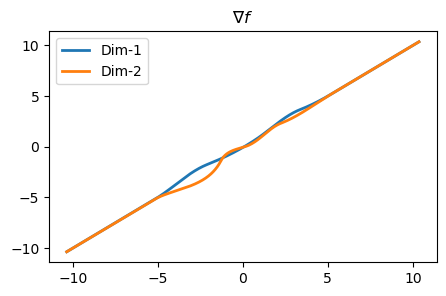

In [9]:
# plot the flow

OT_Trainer.potential_flow_x.plot_flow(1000)

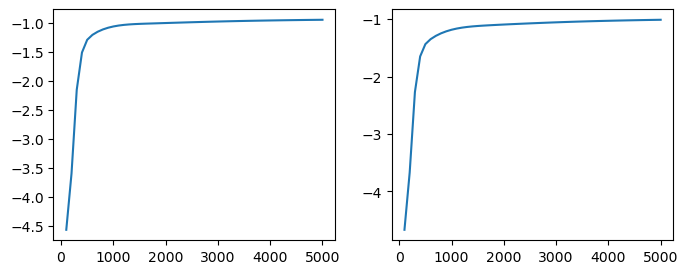

In [10]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
    
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

### Example 3: Custom Spline Dataset

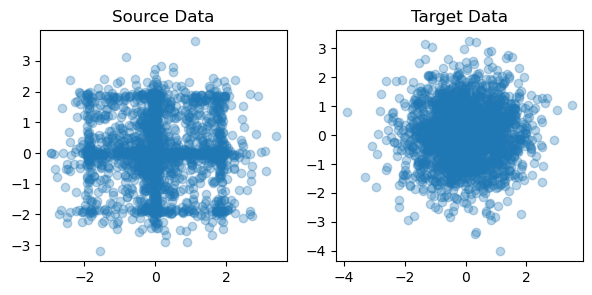

In [2]:
args = parse_arguments()
args.source_dist = 'custom'

# create datasets and dataloaders

dataset_x, dataset_y, true_potential_flow = get_dataset(args)
test_x, test_y, true_potential_flow = get_dataset(args)
data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

# plot data

fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1], alpha=.3)
axs[0].set_title("Source Data")
axs[1].scatter(dataset_y.data[:,0], dataset_y.data[:,1], alpha=.3)
axs[1].set_title("Target Data")
plt.show()

#### Dual Method

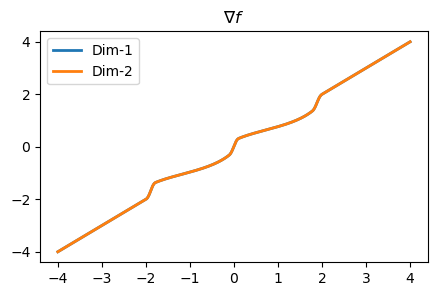

In [3]:
true_potential_flow.plot_flow(1000)

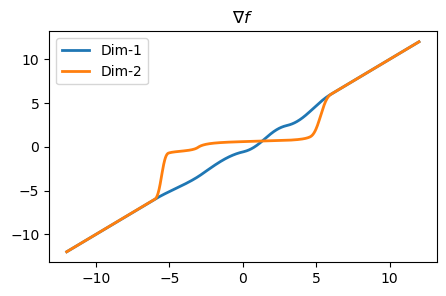

In [4]:
# create flow

torch.manual_seed(42)
tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
potential_flow = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=(2,))

In [ ]:
# train

OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y, true_potential=true_potential_flow)
OT_Trainer.learn()

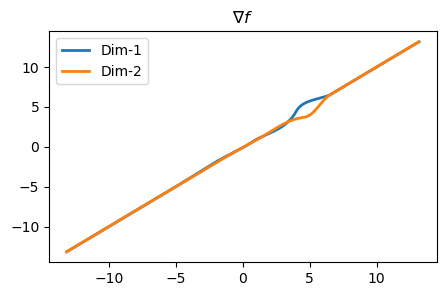

In [6]:
OT_Trainer.args.show_the_plot=True
OT_Trainer.save_figure()

#### Minmax Method

In [ ]:

# create the potential flow for f and g

potential_flow_x = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)
potential_flow_y = potential.ICRQ(tail_bound=args.tail_factor*tail_bound, num_bins=args.num_bins, data_shape=args.data_shape)

potential_flow_x.plot_flow(1000)

In [ ]:
# train

OT_Trainer = flow.MinmaxOT_Trainer(potential_flow_x, potential_flow_y, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)       
OT_Trainer.learn()

In [ ]:
# plot the flow

OT_Trainer.potential_flow_x.plot_flow(1000)

In [ ]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
    
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

In [ ]:
OT_Trainer.args.show_the_plot=True
OT_Trainer.save_figure()